**Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os

np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Agrupamento - Fashion MNIST

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
from PIL import Image

In [4]:
X_train = np.array([X_train[Y_train == i][:600] for i in range(10)]).reshape((6000, 28, 28))

Y_train = np.array([600*[i] for i in range(10)]).reshape((6000,))

In [5]:
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
           5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

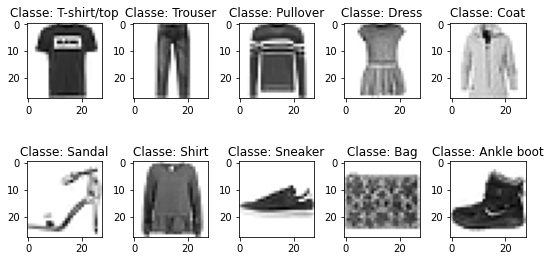

In [6]:
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[Y_train == i][0], cmap='gray_r')
    ax.set_title('Classe: {}'.format(classes[i]))
plt.tight_layout()
plt.show()

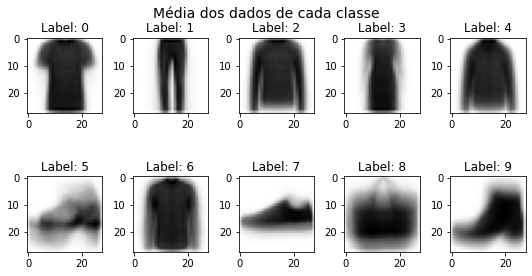

In [7]:
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[Y_train == i].mean(axis=0), cmap='gray_r')
    ax.set_title('Label: {}'.format(i))
plt.tight_layout()
plt.suptitle("Média dos dados de cada classe", fontsize=14)
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
X_train_flat = scaler.fit_transform(X_train.reshape(6000,28**2))

In [10]:
centroides = [np.random.rand(10,28**2) for i in range(10)]

### Aplicação do K-means

In [11]:
from sklearn.cluster import KMeans

melhor_acuracia = 0

for cent_init in centroides:

    kmeans = KMeans(n_clusters = 10, init = cent_init, random_state = 42)

    kmeans.fit(X_train_flat)

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((kmeans.labels_ == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    c = df_cm.copy()
    mapping = {}

    for a in range(10):
        ind_x, ind_y = np.unravel_index(np.argmax(c, axis=None), c.shape)
        mapping[int(c.index[ind_x])] = int(c.columns[ind_y])
        c.drop([c.index[ind_x]], axis=0, inplace=True)
        c.drop([c.columns[ind_y]], axis=1, inplace=True)

    Y_pred = np.array([mapping[x] for x in kmeans.labels_])

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((Y_pred == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    acuracia = np.sum(confusion_matrix.diagonal())/np.sum(confusion_matrix)
    if melhor_acuracia<acuracia:
        melhor_acuracia=acuracia
        melhor_ypred = Y_pred
        melhor_confusion_matrix = confusion_matrix

    print('Acurácia:', acuracia)

Acurácia: 0.52
Acurácia: 0.5128333333333334
Acurácia: 0.554
Acurácia: 0.5871666666666666
Acurácia: 0.45516666666666666
Acurácia: 0.5468333333333333
Acurácia: 0.5021666666666667
Acurácia: 0.44666666666666666
Acurácia: 0.524
Acurácia: 0.4708333333333333


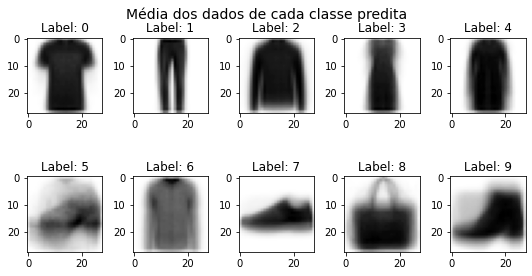

In [12]:
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train_flat.reshape(6000,28,28)[melhor_ypred == i].mean(axis=0), cmap='gray_r')
    ax.set_title('Label: {}'.format(i))
plt.tight_layout()
plt.suptitle("Média dos dados de cada classe predita", fontsize=14)
plt.show()

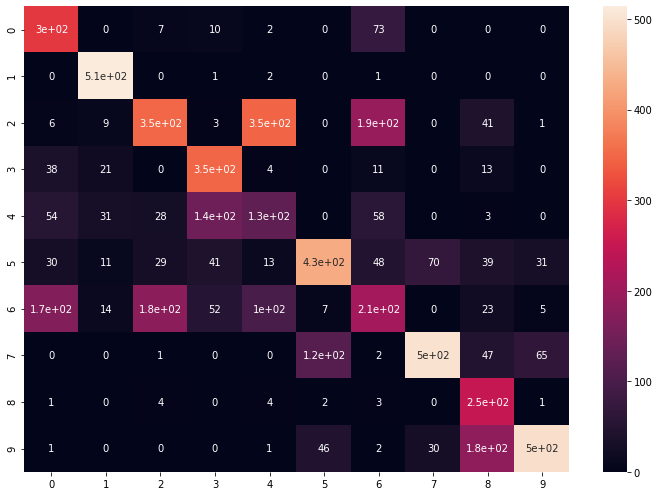

In [13]:
df_cm = pd.DataFrame(melhor_confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.tight_layout()
plt.show()

### Aplicação do K-means adaptativo exato

In [15]:
from hard import kmeans_constraints_exato

melhor_acuracia = 0

for cent_init in [centroides[8]]:

    n_samples = len(X_train_flat)
    clusters = 10

    Z = np.ones((n_samples,))
    mu = Z.sum()/clusters*np.ones((clusters,))

    LABELS = kmeans_constraints_exato(X_train_flat,Z,clusters,cent_init,mu)

    labels = LABELS[-1]

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((labels == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    c = df_cm.copy()
    mapping = {}

    for a in range(10):
        ind_x, ind_y = np.unravel_index(np.argmax(c, axis=None), c.shape)
        mapping[int(c.index[ind_x])] = int(c.columns[ind_y])
        c.drop([c.index[ind_x]], axis=0, inplace=True)
        c.drop([c.columns[ind_y]], axis=1, inplace=True)

    Y_pred = np.array([mapping[x] for x in labels])

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((Y_pred == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    acuracia = np.sum(confusion_matrix.diagonal())/np.sum(confusion_matrix)
    if melhor_acuracia<acuracia:
        melhor_acuracia=acuracia
        melhor_ypred = Y_pred
        melhor_confusion_matrix = confusion_matrix
    
    print('Acurácia:', acuracia)

Acurácia: 0.5441666666666667
Acurácia: 0.5166666666666667
Acurácia: 0.5423333333333333
Acurácia: 0.5371666666666667
Acurácia: 0.6355
Acurácia: 0.5031666666666667
Acurácia: 0.5355
Acurácia: 0.6331666666666667
Acurácia: 0.6355
Acurácia: 0.6315


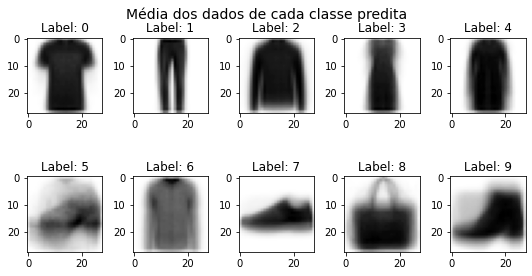

In [16]:
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    try:
        ax.imshow(X_train_flat.reshape(6000,28,28)[melhor_ypred == i].mean(axis=0), cmap='gray_r')
    except:
        pass
    ax.set_title('Label: {}'.format(i))
plt.tight_layout()
plt.suptitle("Média dos dados de cada classe predita", fontsize=14)
plt.show()

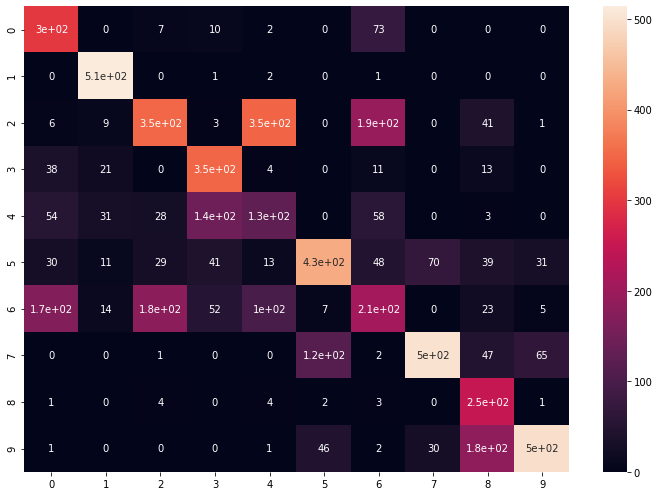

In [17]:
df_cm = pd.DataFrame(melhor_confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.tight_layout()
plt.show()

### Aplicação do K-means adaptativo com função de priorização identidade

In [20]:
from hard import pert_ident, pert_quad, softmax, kmeans_capacity_constraints

melhor_acuracia = 0

for cent_init in centroides:

    n_samples = len(X_train_flat)
    clusters = 10

    Z = np.ones((n_samples,))
    mu = Z.sum()/clusters*np.ones((clusters,))

    LABELS, _ = kmeans_capacity_constraints(X_train_flat,Z,clusters,pert_ident,cent_init,mu)

    labels = LABELS[-1]

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((labels == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    c = df_cm.copy()
    mapping = {}

    for a in range(10):
        ind_x, ind_y = np.unravel_index(np.argmax(c, axis=None), c.shape)
        mapping[int(c.index[ind_x])] = int(c.columns[ind_y])
        c.drop([c.index[ind_x]], axis=0, inplace=True)
        c.drop([c.columns[ind_y]], axis=1, inplace=True)

    Y_pred = np.array([mapping[x] for x in labels])

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((Y_pred == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    acuracia = np.sum(confusion_matrix.diagonal())/np.sum(confusion_matrix)
    if melhor_acuracia<acuracia:
        melhor_acuracia=acuracia
        melhor_ypred = Y_pred
        melhor_confusion_matrix = confusion_matrix
    
    print('Acurácia:', acuracia)

Acurácia: 0.3453333333333333
Acurácia: 0.3458333333333333
Acurácia: 0.3665
Acurácia: 0.3695
Acurácia: 0.4295
Acurácia: 0.3968333333333333
Acurácia: 0.3453333333333333
Acurácia: 0.39016666666666666
Acurácia: 0.42883333333333334
Acurácia: 0.392


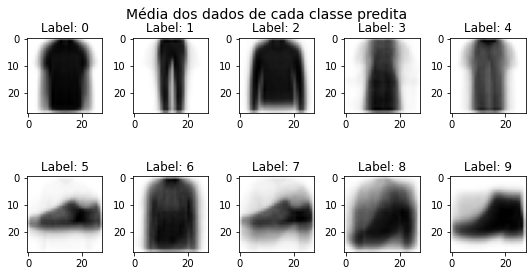

In [16]:
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    try:
        ax.imshow(X_train_flat.reshape(6000,28,28)[melhor_ypred == i].mean(axis=0), cmap='gray_r')
    except:
        pass
    ax.set_title('Label: {}'.format(i))
plt.tight_layout()
plt.suptitle("Média dos dados de cada classe predita", fontsize=14)
plt.show()

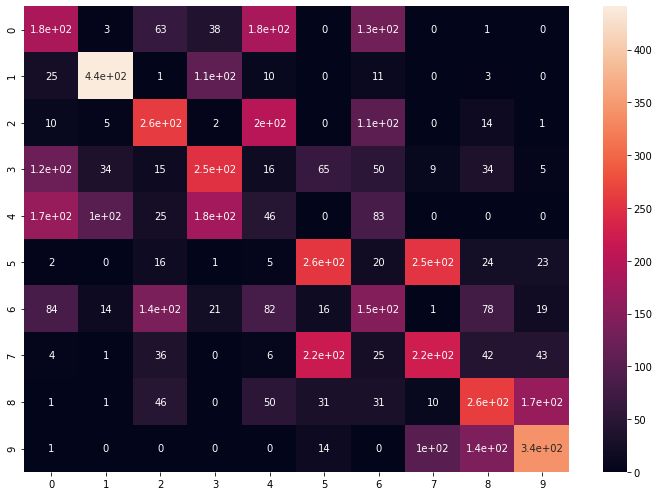

In [17]:
df_cm = pd.DataFrame(melhor_confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.tight_layout()
plt.show()

### Aplicação do K-means adaptativo com função de priorização quadrática

In [21]:
from hard import pert_ident, pert_quad, softmax, kmeans_capacity_constraints

melhor_acuracia = 0

for cent_init in centroides:

    n_samples = len(X_train_flat)
    clusters = 10

    Z = np.ones((n_samples,))
    mu = Z.sum()/clusters*np.ones((clusters,))

    LABELS, _ = kmeans_capacity_constraints(X_train_flat,Z,clusters,pert_quad,cent_init,mu)

    labels = LABELS[-1]

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((labels == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    c = df_cm.copy()
    mapping = {}

    for a in range(10):
        ind_x, ind_y = np.unravel_index(np.argmax(c, axis=None), c.shape)
        mapping[int(c.index[ind_x])] = int(c.columns[ind_y])
        c.drop([c.index[ind_x]], axis=0, inplace=True)
        c.drop([c.columns[ind_y]], axis=1, inplace=True)

    Y_pred = np.array([mapping[x] for x in labels])

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((Y_pred == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    acuracia = np.sum(confusion_matrix.diagonal())/np.sum(confusion_matrix)
    if melhor_acuracia<acuracia:
        melhor_acuracia=acuracia
        melhor_ypred = Y_pred
        melhor_confusion_matrix = confusion_matrix
    
    print('Acurácia:', acuracia)

Acurácia: 0.37516666666666665
Acurácia: 0.3451666666666667
Acurácia: 0.34833333333333333
Acurácia: 0.4
Acurácia: 0.35783333333333334
Acurácia: 0.367
Acurácia: 0.38466666666666666
Acurácia: 0.3908333333333333
Acurácia: 0.4046666666666667
Acurácia: 0.38083333333333336


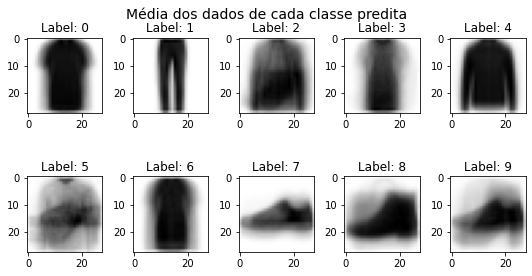

In [22]:
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    try:
        ax.imshow(X_train_flat.reshape(6000,28,28)[melhor_ypred == i].mean(axis=0), cmap='gray_r')
    except:
        pass
    ax.set_title('Label: {}'.format(i))
plt.tight_layout()
plt.suptitle("Média dos dados de cada classe predita", fontsize=14)
plt.show()

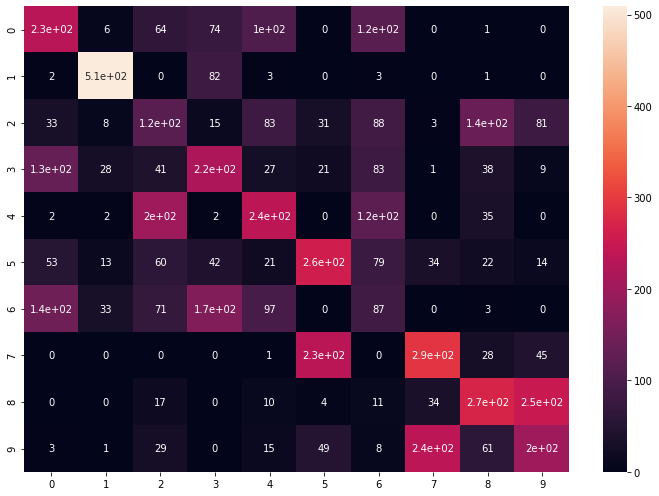

In [23]:
df_cm = pd.DataFrame(melhor_confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.tight_layout()
plt.show()

### Aplicação do K-means adaptativo com função de priorização softmax

In [24]:
from hard import pert_ident, pert_quad, softmax, kmeans_capacity_constraints

melhor_acuracia = 0

for cent_init in centroides:

    n_samples = len(X_train_flat)
    clusters = 10

    Z = np.ones((n_samples,))
    mu = Z.sum()/clusters*np.ones((clusters,))

    LABELS, _ = kmeans_capacity_constraints(X_train_flat,Z,clusters,softmax,cent_init,mu)

    labels = LABELS[-1]

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((labels == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    c = df_cm.copy()
    mapping = {}

    for a in range(10):
        ind_x, ind_y = np.unravel_index(np.argmax(c, axis=None), c.shape)
        mapping[int(c.index[ind_x])] = int(c.columns[ind_y])
        c.drop([c.index[ind_x]], axis=0, inplace=True)
        c.drop([c.columns[ind_y]], axis=1, inplace=True)

    Y_pred = np.array([mapping[x] for x in labels])

    confusion_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = sum((Y_pred == i) & (Y_train == j))

    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    acuracia = np.sum(confusion_matrix.diagonal())/np.sum(confusion_matrix)
    if melhor_acuracia<acuracia:
        melhor_acuracia=acuracia
        melhor_ypred = Y_pred
        melhor_confusion_matrix = confusion_matrix
    
    print('Acurácia:', acuracia)

Acurácia: 0.3998333333333333
Acurácia: 0.4058333333333333
Acurácia: 0.3795
Acurácia: 0.4176666666666667
Acurácia: 0.3426666666666667
Acurácia: 0.4161666666666667
Acurácia: 0.39366666666666666
Acurácia: 0.442
Acurácia: 0.38166666666666665
Acurácia: 0.4523333333333333


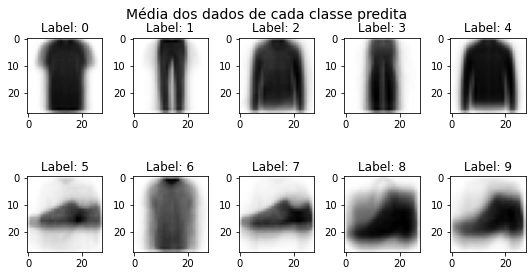

In [25]:
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    try:
        ax.imshow(X_train_flat.reshape(6000,28,28)[melhor_ypred == i].mean(axis=0), cmap='gray_r')
    except:
        pass
    ax.set_title('Label: {}'.format(i))
plt.tight_layout()
plt.suptitle("Média dos dados de cada classe predita", fontsize=14)
plt.show()

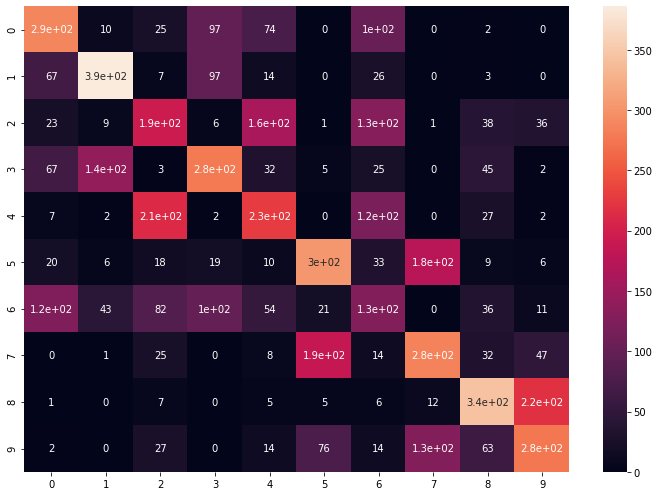

In [26]:
df_cm = pd.DataFrame(melhor_confusion_matrix, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.tight_layout()
plt.show()

In [3]:
boxplot = pd.DataFrame(data = np.array([[0.52, 0.54, 0.34, 0.37, 0.39],
                                        [0.51, 0.51, 0.34, 0.34, 0.40],
                                        [0.55, 0.54, 0.36, 0.34, 0.37],
                                        [0.58, 0.53, 0.36, 0.40, 0.41],
                                        [0.45, 0.63, 0.42, 0.35, 0.34],
                                        [0.54, 0.50, 0.39, 0.36, 0.41],
                                        [0.50, 0.53, 0.34, 0.38, 0.39],
                                        [0.44, 0.63, 0.39, 0.39, 0.44],
                                        [0.52, 0.63, 0.42, 0.40, 0.38],
                                        [0.47, 0.63, 0.39, 0.38, 0.45]]),
                       columns=['K-means','Algoritmo 2', 'Algoritmo 3I',
                                'Algoritmo 3Q','Algoritmo 3S'])

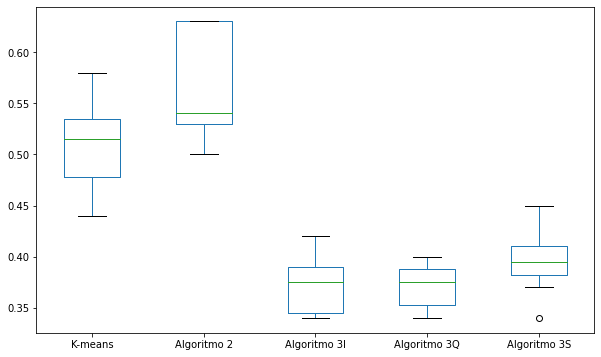

In [4]:
import pandas as pd
fig = plt.figure(figsize=(10,6))
boxplot.boxplot()

plt.grid(None)
#fig.savefig('figures/'+path+'_boxplot.png')
plt.show()